## Assignment S8 :

* Change the dataset to CIFAR10
* Make this network:
C1 C2 c3 P1 C3 C4 C5 c6 P2 C7 C8 C9 GAP C10
* Keep the parameter count less than 50000
* Try and add one layer to another
* Max Epochs is 20
* You are making 3 versions of the above code (in each case achieve above 70% accuracy):
  * Network with Group Normalization
  * Network with Layer Normalization
  * Network with Batch Normalization
* Print 10 Misclassified image.




In [1]:
%load_ext autoreload

In [2]:

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [3]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from utils import test, train, plot_curves,get_incorrect_predictions
from visualize import print_samples,print_class_scale,plot_confusion_matrix,plot_incorrect_predictions
from model import Net
from torchsummary import summary

from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings('ignore')

Defining data tranformations

In [4]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


Downloading MNIST dataset and splitting to train and test set

In [5]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 87837876.59it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
EPOCHS = 20

Creating Data Loaders from train data and test data

In [7]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

kwargs = {'shuffle' : True,'batch_size' : BATCHSIZE,'num_workers': 4, 'pin_memory': True} if cuda else {'shuffle' : True,'batch_size' : BATCHSIZE_2}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs) # creating train data loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs) # creating test dataloader

CUDA Available True


In [8]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']


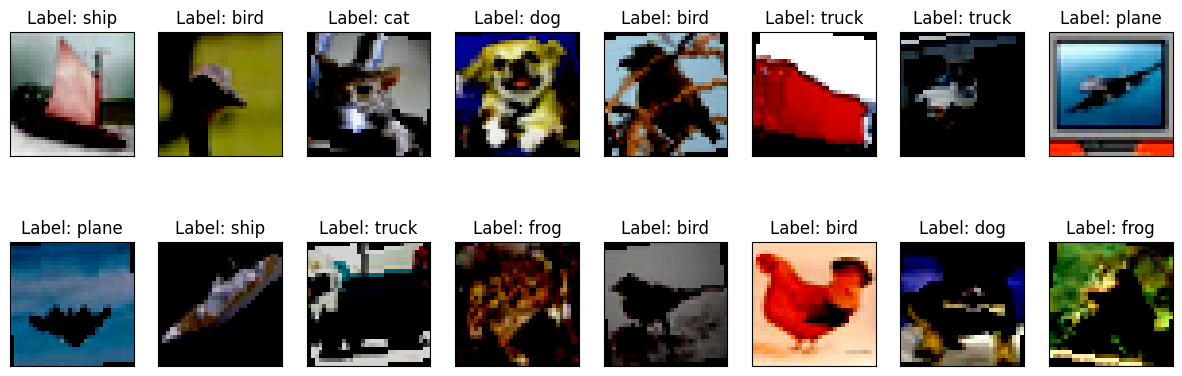

In [9]:
print_samples(train_loader,classes)

Transferring model to GPU and printing model summary

In [10]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = Net(norm="LN").to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             270
         GroupNorm-2           [-1, 10, 32, 32]              20
         Dropout2d-3           [-1, 10, 32, 32]               0
            Conv2d-4           [-1, 10, 32, 32]             900
         GroupNorm-5           [-1, 10, 32, 32]              20
         Dropout2d-6           [-1, 10, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             160
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           3,456
        GroupNorm-10           [-1, 24, 16, 16]              48
        Dropout2d-11           [-1, 24, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           3,456
        GroupNorm-13           [-1, 16, 16, 16]              32
        Dropout2d-14           [-1, 16,

In [11]:
model =  Net(norm='LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)

EPOCH: 0


Train: Loss=1.6629 Batch_id=390 Accuracy=33.85: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Test set: Average loss: 1.5198, Accuracy: 4401/10000 (44.01%)

EPOCH: 1


Train: Loss=1.2150 Batch_id=390 Accuracy=47.80: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


Test set: Average loss: 1.2802, Accuracy: 5402/10000 (54.02%)

EPOCH: 2


Train: Loss=1.1891 Batch_id=390 Accuracy=53.83: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]


Test set: Average loss: 1.1644, Accuracy: 5814/10000 (58.14%)

EPOCH: 3


Train: Loss=1.0607 Batch_id=390 Accuracy=58.52: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


Test set: Average loss: 1.0816, Accuracy: 6098/10000 (60.98%)

EPOCH: 4


Train: Loss=0.9321 Batch_id=390 Accuracy=61.04: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]


Test set: Average loss: 1.0223, Accuracy: 6337/10000 (63.37%)

EPOCH: 5


Train: Loss=1.1917 Batch_id=390 Accuracy=63.51: 100%|██████████| 391/391 [00:44<00:00,  8.69it/s]


Test set: Average loss: 0.9861, Accuracy: 6543/10000 (65.43%)

EPOCH: 6


Train: Loss=1.1026 Batch_id=390 Accuracy=65.20: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


Test set: Average loss: 0.9284, Accuracy: 6647/10000 (66.47%)

EPOCH: 7


Train: Loss=0.7711 Batch_id=390 Accuracy=66.68: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


Test set: Average loss: 0.8740, Accuracy: 6966/10000 (69.66%)

EPOCH: 8


Train: Loss=1.0750 Batch_id=390 Accuracy=68.00: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Test set: Average loss: 0.8401, Accuracy: 7059/10000 (70.59%)

EPOCH: 9


Train: Loss=0.6930 Batch_id=390 Accuracy=69.12: 100%|██████████| 391/391 [00:45<00:00,  8.58it/s]


Test set: Average loss: 0.7987, Accuracy: 7222/10000 (72.22%)

EPOCH: 10


Train: Loss=0.7833 Batch_id=390 Accuracy=70.04: 100%|██████████| 391/391 [00:44<00:00,  8.69it/s]


Test set: Average loss: 0.8087, Accuracy: 7219/10000 (72.19%)

EPOCH: 11


Train: Loss=0.9617 Batch_id=390 Accuracy=70.92: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Test set: Average loss: 0.7607, Accuracy: 7376/10000 (73.76%)

EPOCH: 12


Train: Loss=0.9863 Batch_id=390 Accuracy=71.45: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


Test set: Average loss: 0.7994, Accuracy: 7245/10000 (72.45%)

EPOCH: 13


Train: Loss=0.9062 Batch_id=390 Accuracy=72.25: 100%|██████████| 391/391 [00:45<00:00,  8.58it/s]


Test set: Average loss: 0.7556, Accuracy: 7362/10000 (73.62%)

EPOCH: 14


Train: Loss=0.7975 Batch_id=390 Accuracy=73.00: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]


Test set: Average loss: 0.7180, Accuracy: 7507/10000 (75.07%)

EPOCH: 15


Train: Loss=0.9532 Batch_id=390 Accuracy=73.11: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]


Test set: Average loss: 0.7115, Accuracy: 7559/10000 (75.59%)

EPOCH: 16


Train: Loss=0.8164 Batch_id=390 Accuracy=73.50: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]


Test set: Average loss: 0.7114, Accuracy: 7520/10000 (75.20%)

EPOCH: 17


Train: Loss=0.5469 Batch_id=390 Accuracy=74.04: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]


Test set: Average loss: 0.7056, Accuracy: 7563/10000 (75.63%)

EPOCH: 18


Train: Loss=0.4695 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]


Test set: Average loss: 0.6849, Accuracy: 7630/10000 (76.30%)

EPOCH: 19


Train: Loss=0.6269 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


Test set: Average loss: 0.6695, Accuracy: 7706/10000 (77.06%)



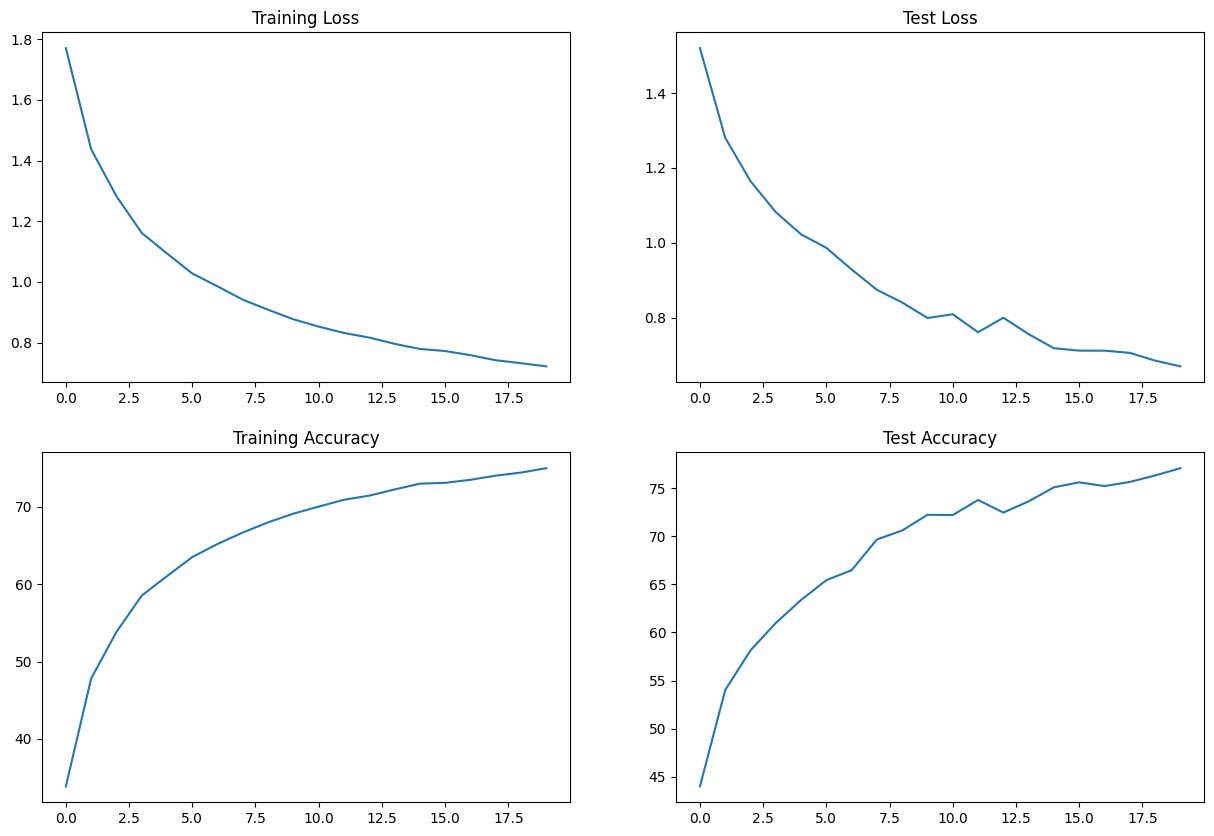

In [12]:
plot_curves()

In [13]:
wrong_prediction_list = get_incorrect_predictions(model,test_loader,device)

Total Incorrect Predictions 2294


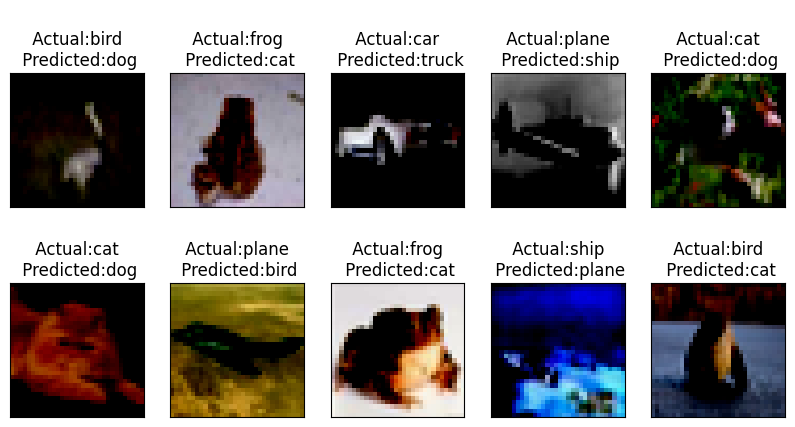

In [14]:
plot_incorrect_predictions(wrong_prediction_list,classes)

## Confusion Matrix

Confusion matrix, without normalization


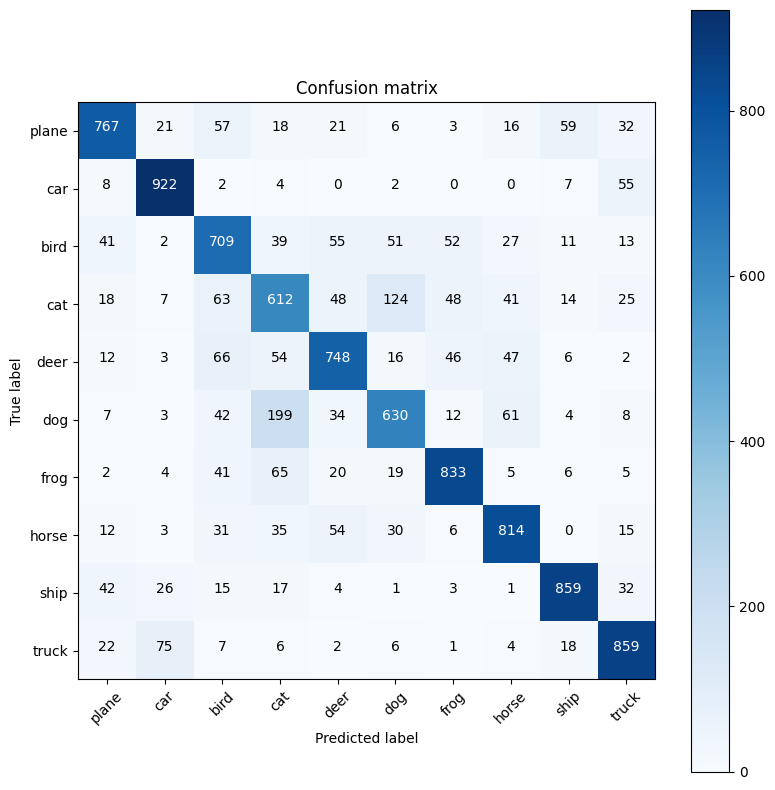

In [ ]:
from utils import get_all_predictions, get_incorrect_predictions, prepare_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, classes)
plot_confusion_matrix(confusion_matrix, classes, False)

## Save Model

In [15]:
torch.save(model.state_dict(), 'model_LN.pth')

In [ ]:
# Load Model
#model = Net(norm="BN").to(device)
#model.load_state_dict(torch.load('model_bn.pth'))

<All keys matched successfully>